In [723]:
import sys 
print(sys.version)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [724]:
import os
import copy
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from bertModel import BertClassification, dense_opt
from datasets import text_dataset, financialPhraseBankDataset
import argparse
from sklearn.metrics import f1_score

In [725]:
labels = {0:'neutral', 1:'positive',2:'negative'}
num_labels= len(labels)
vocab ="finance-uncased"
vocab_path = '/Users/svetlana/Downloads/analyst_tone-2/vocab' 
pretrained_weights_path ='/Users/svetlana/Downloads/analyst_tone-2/pretrained_weights'
fine_tuned_weight_path = '/Users/svetlana/Downloads/analyst_tone-2/fine_tuned.pth'   
max_seq_length = 512
device=torch.device("cpu")

In [726]:
model = BertClassification(weight_path = pretrained_weights_path, 
                           num_labels=num_labels, vocab=vocab)

/Users/svetlana/finBERT/from git/bertModel.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.classifier.weight)


In [727]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30873, 768])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
bert.embeddings.LayerNorm.weight 	 torch.Size([768])
bert.embeddings.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.0.attention.outp

In [728]:
model.load_state_dict(torch.load(fine_tuned_weight_path, map_location=device))
model.to(device)

BertClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


# 0 is neutral, 1 is positive, and 2 is negative 

In [729]:
import glob
import csv
import pandas as pd
text_path = '/Users/svetlana/Desktop/Creation/*'
files = glob.glob(text_path)

In [730]:
sentences = []
length_sent = []
for file in files:
    with open(file) as f:
        sentence = f.read().strip().split('\n')
    sentences.append(sentence)

In [731]:
from collections import defaultdict
groups = defaultdict(list)
roots = []
tickers = []
dates = []
for file in files:
    basename = os.path.basename(file)
    root, extension = os.path.splitext(basename)
    roots.append(root)
    for root in roots:
        ticker = str(root).split()[0]
        date = str(root).split()[1]
    tickers.append(ticker)
    dates.append(date)

In [732]:
import datetime
import timedelta
import pandas as pd
df = pd.DataFrame()

In [733]:
df['ticker'] = tickers
df['dates'] = dates

In [734]:
df['date'] = pd.to_datetime(df['dates'], format="%d%m%Y", infer_datetime_format=True)
df = df.drop(columns = ['dates'])
df.head()

,ticker,date
0,MUR,2018-10-10
1,ADM,2018-10-29
2,LYB,2020-10-02
3,RPT,2019-12-10
4,GOLD,2019-03-11


In [735]:
from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import *

In [736]:
from pandas.tseries.offsets import BDay

In [737]:
percentage_list = []
#T1_percentage_list = []
for ticker, date  in zip(df.ticker, df.date): 
    price_data = float(si.get_data(ticker, start_date = date, 
                             end_date = date+BDay(1))['close'])
    previous_price_data = float(si.get_data(ticker, start_date = date-BDay(1), 
                             end_date = date)['close'])
    #next_price_data = float(si.get_data(ticker, start_date = next_date+BDay(2), 
                             #end_date = next_date+BDay(3))['close'])
    price_change_T0 = (price_data / previous_price_data) - 1
    #price_change_T1 = (next_price_data / price_data) - 1                        
    percentage = price_change_T0*100
    #T1_percentage = price_change_T1*100                        
    percentage_list.append(percentage)
    #T1_percentage_list.append(T1_percentage)

In [738]:
df['%_change'] = percentage_list
#df['T1_%_change'] = T1_percentage_list
df

,ticker,date,%_change
0,MUR,2018-10-10,-6.283189
1,ADM,2018-10-29,1.183812
2,LYB,2020-10-02,6.017022
3,RPT,2019-12-10,0.068401
4,GOLD,2019-03-11,1.933488
5,BWXT,2021-03-08,0.401676
6,INFY,2018-09-07,0.240390
7,LOW,2009-09-24,-0.650261
8,ARES,2021-02-25,-1.053840
9,TOL,2020-04-20,-7.100317


In [739]:
def price_change(df):
    if df['%_change']>= 0.8:
        return 'Price up'
    elif -0.8 < df['%_change'] < 0.8: 
        return 'Price neutral'
    else:
        return 'Price down'
df['price_change'] = df.apply(price_change, axis=1)
df.head()

,ticker,date,%_change,price_change
0,MUR,2018-10-10,-6.283189,Price down
1,ADM,2018-10-29,1.183812,Price up
2,LYB,2020-10-02,6.017022,Price up
3,RPT,2019-12-10,0.068401,Price neutral
4,GOLD,2019-03-11,1.933488,Price up


In [740]:
def price_change2(df):
    if df['%_change']>0:
        return 'Price up'
    else:
        return 'Price down'
df['price_change2'] = df.apply(price_change2, axis=1)
df.head()

,ticker,date,%_change,price_change,price_change2
0,MUR,2018-10-10,-6.283189,Price down,Price down
1,ADM,2018-10-29,1.183812,Price up,Price up
2,LYB,2020-10-02,6.017022,Price up,Price up
3,RPT,2019-12-10,0.068401,Price neutral,Price up
4,GOLD,2019-03-11,1.933488,Price up,Price up


/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


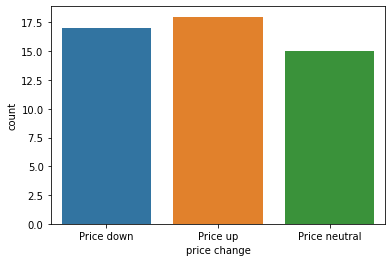

In [741]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df['price_change'])
plt.xlabel('price change');

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price_change2', ylabel='count'>

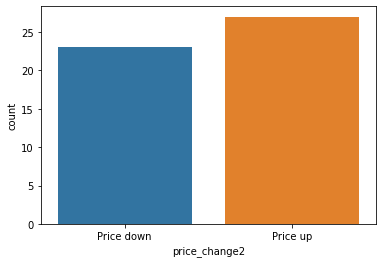

In [742]:
sns.countplot(df['price_change2'])

In [743]:
import transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, 
                          do_basic_tokenize = True)
from torch import Tensor

In [744]:
def sentiment_function(sentences):
    for sent in sentences:
        encoded_data = tokenizer.batch_encode_plus(
            sentences, add_special_tokens = True,
            return_attention_mask = True,
            max_length = max_seq_length,
            stride = 2,
            pad_to_max_length = True,
            return_tensors = 'pt')
        
    labels = torch.empty(len(sentences), dtype=torch.long)
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(labels)
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    batch_size = 32
    
    dataloader = DataLoader(
        dataset, 
        sampler = SequentialSampler(dataset),
        batch_size=batch_size)
    
    def predict(dataloader_):
        model.eval()
        predictions = []
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2],
                     }
            with torch.no_grad():
                outputs = model(**inputs)
        
            outputs = F.softmax(outputs,dim=1)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
        
            predictions.append(outputs)
        
        predictions = np.concatenate(predictions, axis = 0)
    
        return predictions
    
    pred = predict(dataloader_ = dataloader)
    
    positives = 0
    negatives = 0
    neutrals = 0
    sentiment = []
    for i in range(len(pred)):
        pred_labels_i = np.argmax(pred[i]).flatten()
        sentiment.append(pred_labels_i[0])
        if pred_labels_i[0] == 1:
            positives+=1
        elif pred_labels_i[0] == 2:
            negatives+=1
        elif pred_labels_i[0] == 0:
            neutrals+=1
    return(positives, negatives, neutrals, sentiment) 

In [745]:
positive_sent = []
negative_sent = []
neutral_sent = []
sent_list = []
for sentence in sentences:
    a = sentiment_function(sentence)
    positive_sent.append(a[0])
    negative_sent.append(a[1])
    neutral_sent.append(a[2])
    sent_list.append(a[3])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-pack

In [746]:
df['positive_sent'] = positive_sent
df['negative_sent'] = negative_sent
df['neutral_sent'] = neutral_sent
df

,ticker,date,%_change,price_change,price_change2,positive_sent,negative_sent,neutral_sent
0,MUR,2018-10-10,-6.283189,Price down,Price down,4,0,6
1,ADM,2018-10-29,1.183812,Price up,Price up,6,0,3
2,LYB,2020-10-02,6.017022,Price up,Price up,6,0,5
3,RPT,2019-12-10,0.068401,Price neutral,Price up,5,0,12
4,GOLD,2019-03-11,1.933488,Price up,Price up,2,0,1
5,BWXT,2021-03-08,0.401676,Price neutral,Price up,2,0,3
6,INFY,2018-09-07,0.240390,Price neutral,Price up,4,0,4
7,LOW,2009-09-24,-0.650261,Price neutral,Price down,3,0,3
8,ARES,2021-02-25,-1.053840,Price down,Price down,6,0,24
9,TOL,2020-04-20,-7.100317,Price down,Price down,3,0,2


In [747]:
df['length'] = df['positive_sent'] + df['negative_sent'] + df['neutral_sent']
df

,ticker,date,%_change,price_change,price_change2,positive_sent,negative_sent,neutral_sent,length
0,MUR,2018-10-10,-6.283189,Price down,Price down,4,0,6,10
1,ADM,2018-10-29,1.183812,Price up,Price up,6,0,3,9
2,LYB,2020-10-02,6.017022,Price up,Price up,6,0,5,11
3,RPT,2019-12-10,0.068401,Price neutral,Price up,5,0,12,17
4,GOLD,2019-03-11,1.933488,Price up,Price up,2,0,1,3
5,BWXT,2021-03-08,0.401676,Price neutral,Price up,2,0,3,5
6,INFY,2018-09-07,0.240390,Price neutral,Price up,4,0,4,8
7,LOW,2009-09-24,-0.650261,Price neutral,Price down,3,0,3,6
8,ARES,2021-02-25,-1.053840,Price down,Price down,6,0,24,30
9,TOL,2020-04-20,-7.100317,Price down,Price down,3,0,2,5


In [748]:
df['norm_positive_sent'] = df['positive_sent'] / df['length']
df['norm_neutral_sent'] = df['neutral_sent'] / df['length']
df['norm_negative_sent'] = df['negative_sent'] / df['length']
df['total_sentiment'] = (df['norm_positive_sent']*2) / (df['norm_neutral_sent'] *0.5 + df['norm_negative_sent']*2 + 1)
df

,ticker,date,%_change,price_change,price_change2,positive_sent,negative_sent,neutral_sent,length,norm_positive_sent,norm_neutral_sent,norm_negative_sent,total_sentiment
0,MUR,2018-10-10,-6.283189,Price down,Price down,4,0,6,10,0.400000,0.600000,0.000000,0.615385
1,ADM,2018-10-29,1.183812,Price up,Price up,6,0,3,9,0.666667,0.333333,0.000000,1.142857
2,LYB,2020-10-02,6.017022,Price up,Price up,6,0,5,11,0.545455,0.454545,0.000000,0.888889
3,RPT,2019-12-10,0.068401,Price neutral,Price up,5,0,12,17,0.294118,0.705882,0.000000,0.434783
4,GOLD,2019-03-11,1.933488,Price up,Price up,2,0,1,3,0.666667,0.333333,0.000000,1.142857
5,BWXT,2021-03-08,0.401676,Price neutral,Price up,2,0,3,5,0.400000,0.600000,0.000000,0.615385
6,INFY,2018-09-07,0.240390,Price neutral,Price up,4,0,4,8,0.500000,0.500000,0.000000,0.800000
7,LOW,2009-09-24,-0.650261,Price neutral,Price down,3,0,3,6,0.500000,0.500000,0.000000,0.800000
8,ARES,2021-02-25,-1.053840,Price down,Price down,6,0,24,30,0.200000,0.800000,0.000000,0.285714
9,TOL,2020-04-20,-7.100317,Price down,Price down,3,0,2,5,0.600000,0.400000,0.000000,1.000000


# Adding regression analysis

In [749]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [750]:
import statsmodels.api as sm

In [751]:
from scipy.stats import shapiro
stat, p = shapiro(df['total_sentiment'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.946, p=0.024
Probably not Gaussian


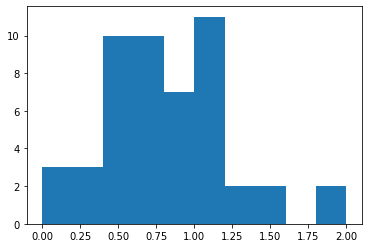

In [752]:
import matplotlib.pyplot as plt
plt.hist(df['total_sentiment'])
plt.show()

In [753]:
from scipy.stats import t
from scipy.stats import norm
from scipy import stats

In [754]:
stat, p = shapiro(df['%_change'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.894, p=0.000
Probably not Gaussian


<AxesSubplot:>

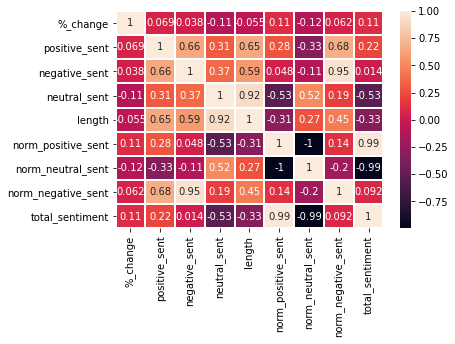

In [755]:
import seaborn as sns
sns.heatmap(df.corr(), annot = True, lw = 1)

In [756]:
X = df[['length', 'total_sentiment']]
y = df['%_change']
y = pd.to_numeric(y)

In [757]:
model = sm.OLS(y.astype(float), X.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               %_change   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):             -0.028
Method:                 Least Squares   F-statistic:                             0.3215
Date:                Sat, 20 Mar 2021   Prob (F-statistic):                       0.727
Time:                        15:44:17   Log-Likelihood:                         -125.98
No. Observations:                  50   AIC:                                      256.0
Df Residuals:                      48   BIC:                                      259.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
length             -0.0374      0.048     -0.778      0.440      -0.134       0.059
total_sentiment     0.2097      0.621      0.338      0.737      -1.039       1.458
==============================================================================
Omnibus:                       18.196   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.504
Skew:                          -1.191   Prob(JB):                     1.76e-06
Kurtosis:                       5.655   Cond. No.                         16.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [758]:
price_up = df[df['%_change']>0]
price_down = df[df['%_change']<=0]

In [759]:
price_up.median()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


%_change              1.118883
positive_sent         3.000000
negative_sent         0.000000
neutral_sent          3.000000
length                6.000000
norm_positive_sent    0.500000
norm_neutral_sent     0.500000
norm_negative_sent    0.000000
total_sentiment       0.800000
dtype: float64

In [760]:
price_down.median()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


%_change             -1.325233
positive_sent         4.000000
negative_sent         0.000000
neutral_sent          4.000000
length                8.000000
norm_positive_sent    0.400000
norm_neutral_sent     0.600000
norm_negative_sent    0.000000
total_sentiment       0.615385
dtype: float64

In [761]:
p_value = stats.mannwhitneyu(price_up['total_sentiment'], price_down['total_sentiment'])
print(p_value)

MannwhitneyuResult(statistic=267.0, pvalue=0.20059204586514418)


In [762]:
price_up = df[df['%_change']>0.8]
no_price_change = df[df['%_change'].between (-0.8, 0.8)]
price_down = df[df['%_change']<-0.8]

In [763]:
stats.kruskal(price_up['total_sentiment'], no_price_change['total_sentiment'], 
              price_down['total_sentiment'])

KruskalResult(statistic=2.842412699585376, pvalue=0.24142260105292562)

In [764]:
stats.kruskal(price_up['length'], no_price_change['length'], 
              price_down['length'])

KruskalResult(statistic=3.361187115671371, pvalue=0.18626338512986124)

In [765]:
dominant_topic = pd.read_csv("Dominant_topic.csv") 

In [766]:
dominant_topic

,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,4.0,0.9988,"product, company, transaction, expect, consume...","['archer', 'daniel', 'midland', 'company', 'ca..."
1,1,1,1.0,0.9594,"company, platform, solution, technology, custo...","['chouston', 'johannesburg', '/prnewswire/', '..."
2,2,2,0.0,0.6265,"center, market, business, company, global, pri...","['globe', 'newswire', 'realty', 'company', 'pu..."
3,3,3,3.0,0.6460,"company, business, global, cloud, property, ca...","['baltimore', 'march', 'barrick', 'corporation..."
4,4,4,4.0,0.7535,"product, company, transaction, expect, consume...","['lynchburg', 'va.--(business', 'wire)--bwxt',..."
5,5,5,3.0,0.7557,"company, business, global, cloud, property, ca...","['infosys', 'global', 'leader', 'consult', 'te..."
6,6,6,3.0,0.9991,"company, business, global, cloud, property, ca...","['mooresville', '/prnewswire', 'firstcall/', '..."
7,7,7,3.0,0.9989,"company, business, global, cloud, property, ca...","['sydney', 'york--(business', 'wire)--amp', 'l..."
8,8,8,0.0,0.9996,"center, market, business, company, global, pri...","['horsham', 'april', 'globe', 'newswire', 'bro..."
9,9,9,2.0,0.9989,"project, development, lease, railcar, investme...","['columbia', 'md.--(business', 'wire)--corpora..."


In [767]:
df['Topic'] = dominant_topic['Dominant_Topic'] 

In [768]:
dummies = pd.get_dummies(df['Topic'], prefix = 'Topic')
df = pd.concat([df, dummies], axis=1)      
df.drop(['Topic'], inplace=True, axis=1)

In [769]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ticker              50 non-null     object        
 1   date                50 non-null     datetime64[ns]
 2   %_change            50 non-null     float64       
 3   price_change        50 non-null     object        
 4   price_change2       50 non-null     object        
 5   positive_sent       50 non-null     int64         
 6   negative_sent       50 non-null     int64         
 7   neutral_sent        50 non-null     int64         
 8   length              50 non-null     int64         
 9   norm_positive_sent  50 non-null     float64       
 10  norm_neutral_sent   50 non-null     float64       
 11  norm_negative_sent  50 non-null     float64       
 12  total_sentiment     50 non-null     float64       
 13  Topic_0.0           50 non-null     uint8         
 

In [770]:
df.head()

,ticker,date,%_change,price_change,price_change2,positive_sent,negative_sent,neutral_sent,length,norm_positive_sent,norm_neutral_sent,norm_negative_sent,total_sentiment,Topic_0.0,Topic_1.0,Topic_2.0,Topic_3.0,Topic_4.0
0,MUR,2018-10-10,-6.283189,Price down,Price down,4,0,6,10,0.400000,0.600000,0.0,0.615385,0,0,0,0,1
1,ADM,2018-10-29,1.183812,Price up,Price up,6,0,3,9,0.666667,0.333333,0.0,1.142857,0,1,0,0,0
2,LYB,2020-10-02,6.017022,Price up,Price up,6,0,5,11,0.545455,0.454545,0.0,0.888889,1,0,0,0,0
3,RPT,2019-12-10,0.068401,Price neutral,Price up,5,0,12,17,0.294118,0.705882,0.0,0.434783,0,0,0,1,0
4,GOLD,2019-03-11,1.933488,Price up,Price up,2,0,1,3,0.666667,0.333333,0.0,1.142857,0,0,0,0,1


In [771]:
X = df[['length', 'total_sentiment', 'Topic_0.0', 'Topic_1.0', 'Topic_2.0', 'Topic_3.0', 
        'Topic_4.0']]
y = df['price_change']
X.head()

,length,total_sentiment,Topic_0.0,Topic_1.0,Topic_2.0,Topic_3.0,Topic_4.0
0,10,0.615385,0,0,0,0,1
1,9,1.142857,0,1,0,0,0
2,11,0.888889,1,0,0,0,0
3,17,0.434783,0,0,0,1,0
4,3,1.142857,0,0,0,0,1


In [772]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True,
                                                    random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [773]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.69
Accuracy of Logistic regression classifier on test set: 0.60


In [774]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dt_clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dt_clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.94
Accuracy of Decision Tree classifier on test set: 0.47


In [775]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(X_train, y_train)
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.94
Accuracy of Random Forest classifier on test set: 0.47


In [776]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.63
Accuracy of K-NN classifier on test set: 0.33


In [777]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.71
Accuracy of LDA classifier on test set: 0.53


In [778]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.54
Accuracy of GNB classifier on test set: 0.40


In [779]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.66
Accuracy of SVM classifier on test set: 0.53


In [780]:
from sklearn.metrics import confusion_matrix, classification_report

In [781]:
pred = dt_clf.predict(X_test)

In [782]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[1 1 3]
 [2 1 2]
 [0 0 5]]
               precision    recall  f1-score   support

   Price down       0.33      0.20      0.25         5
Price neutral       0.50      0.20      0.29         5
     Price up       0.50      1.00      0.67         5

     accuracy                           0.47        15
    macro avg       0.44      0.47      0.40        15
 weighted avg       0.44      0.47      0.40        15



In [789]:
df['norm_neutral_sent'].median()

0.5277777777777778

In [790]:
4/50

0.08